# テキストデータの可視化

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shinchu/dataviz-notebooks/blob/main/week_5/intro-to-visualizing-text-data.ipynb)

今回は、[青空文庫](https://www.aozora.gr.jp/)に収録されている、夏目漱石の[『三四郎』](https://www.aozora.gr.jp/cards/000148/card794.html)という作品を使って、テキストデータの可視化を練習します。

## 基礎的な解析

In [1]:
# ライブラリのインストール

!pip install ginza==4.0.6 ja-ginza==4.0.0
!pip install sklearn pandas


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# ファイルをダウンロードする
!wget https://www.aozora.gr.jp/cards/000148/files/794_ruby_4237.zip
# textフォルダ作る
!mkdir -p text
# ファイルをtextフォルダに解凍
!unzip -d text -o 794_ruby_4237.zip

--2022-11-09 15:16:51--  https://www.aozora.gr.jp/cards/000148/files/794_ruby_4237.zip
Resolving proxy.noc.titech.ac.jp (proxy.noc.titech.ac.jp)... 131.112.125.238
Connecting to proxy.noc.titech.ac.jp (proxy.noc.titech.ac.jp)|131.112.125.238|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 158711 (155K) [application/zip]
Saving to: ‘794_ruby_4237.zip’

794_ruby_4237.zip   100%[===================>] 154.99K  --.-KB/s    in 0.01s   

2022-11-09 15:16:51 (14.1 MB/s) - ‘794_ruby_4237.zip’ saved [158711/158711]

Archive:  794_ruby_4237.zip
  inflating: text/sanshiro.txt       


正規表現で青空文庫のルビ、注、アクセントの記号を取り除きます。

同時に、文字コードをShift-JISからUTF-8にします。

```

-------------------------------------------------------
【テキスト中に現れる記号について】

《》：ルビ
（例）頓狂《とんきょう》

｜：ルビの付く文字列の始まりを特定する記号
（例）福岡県｜京都郡《みやこぐん》

［＃］：入力者注　主に外字の説明や、傍点の位置の指定
　　　（数字は、JIS X 0213の面区点番号またはUnicode、底本のページと行数）
（例）※［＃「魚＋師のつくり」、第4水準2-93-37］

〔〕：アクセント分解された欧文をかこむ
（例）〔ve'rite'《ヴェリテ》 vraie《ヴレイ》.〕
アクセント分解についての詳細は下記URLを参照してください
http://www.aozora.gr.jp/accent_separation.html
-------------------------------------------------------

```

In [18]:
import re

input_fn = "text/sanshiro.txt"
output_fn = "text/sanshiro.stripruby.txt"

with open(input_fn, encoding="shift_jis") as fin, open(output_fn, mode="w") as fout:
    for line in fin:
        fout.write(re.sub(r"《[^》]+》|［[^］]+］|〔[^〕]+〕| [｜]", "", line))

冒頭と末尾の説明を取り除きます（何行取り除くかは目視で確認）。

In [22]:
!tail -n +22 text/sanshiro.stripruby.txt | head -n -14 > text/sanshiro.corpus.txt

これで、テキストファイルを扱う準備ができました。

### 形態素解析

形態素解析は、文章を一つ一つの形態素に分ける技術です。形態素は、「言葉が意味を持つまとまりの単語の最小単位」です。

spaCyで日本語の形態素解析モデル（`ja_ginza`）をロードして、形態素解析をしてみましょう。

In [1]:
import spacy

nlp = spacy.load("ja_ginza")
text = "これは文章です。"
doc = nlp(text)
for token in doc:
    print(token)

これ
は
文章
です
。


形態素解析の結果には、語の原形や品詞の情報も含まれます。

In [36]:
text = "昨日の天気は晴れでした。明日も晴れるでしょう。"
doc = nlp(text)
for token in doc:
    print(f"{token}\t{token.lemma_}\t{token.pos_}\t{token.tag_}")

昨日	昨日	NOUN	名詞-普通名詞-副詞可能
の	の	ADP	助詞-格助詞
天気	天気	NOUN	名詞-普通名詞-一般
は	は	ADP	助詞-係助詞
晴れ	晴れ	NOUN	名詞-普通名詞-一般
でし	です	AUX	助動詞
た	た	AUX	助動詞
。	。	PUNCT	補助記号-句点
明日	明日	NOUN	名詞-普通名詞-副詞可能
も	も	ADP	助詞-係助詞
晴れる	晴れる	VERB	動詞-一般
でしょう	です	AUX	助動詞
。	。	PUNCT	補助記号-句点


In [59]:
text = "うとうととして目がさめると女はいつのまにか、隣のじいさんと話を始めている。このじいさんはたしかに前の前の駅から乗ったいなか者である。発車まぎわに頓狂な声を出して駆け込んで来て、いきなり肌をぬいだと思ったら背中にお灸のあとがいっぱいあったので、三四郎の記憶に残っている。じいさんが汗をふいて、肌を入れて、女の隣に腰をかけたまでよく注意して見ていたくらいである。"
doc = nlp(text)
for token in doc:
    print(f"{token}\t{token.lemma_}\t{token.pos_}\t{token.tag_}")

うとうと	うとうと	ADV	副詞
と	と	ADP	助詞-格助詞
し	する	VERB	動詞-非自立可能
て	て	SCONJ	助詞-接続助詞
目	目	NOUN	名詞-普通名詞-一般
が	が	ADP	助詞-格助詞
さめる	さめる	VERB	動詞-一般
と	と	ADP	助詞-格助詞
女	女	NOUN	名詞-普通名詞-一般
は	は	ADP	助詞-係助詞
いつ	いつ	PRON	代名詞
の	の	ADP	助詞-格助詞
ま	ま	NOUN	名詞-普通名詞-助数詞可能
に	に	ADP	助詞-格助詞
か	か	ADP	助詞-副助詞
、	、	PUNCT	補助記号-読点
隣	隣	NOUN	名詞-普通名詞-一般
の	の	ADP	助詞-格助詞
じい	じい	NOUN	名詞-普通名詞-一般
さん	さん	NOUN	接尾辞-名詞的-一般
と	と	ADP	助詞-格助詞
話	話	NOUN	名詞-普通名詞-サ変可能
を	を	ADP	助詞-格助詞
始め	始める	VERB	動詞-非自立可能
て	て	SCONJ	助詞-接続助詞
いる	いる	AUX	動詞-非自立可能
。	。	PUNCT	補助記号-句点
この	この	DET	連体詞
じい	じい	NOUN	名詞-普通名詞-一般
さん	さん	NOUN	接尾辞-名詞的-一般
は	は	ADP	助詞-係助詞
たしか	たしか	ADJ	形状詞-一般
に	だ	AUX	助動詞
前	前	NOUN	名詞-普通名詞-副詞可能
の	の	ADP	助詞-格助詞
前	前	NOUN	名詞-普通名詞-副詞可能
の	の	ADP	助詞-格助詞
駅	駅	NOUN	名詞-普通名詞-一般
から	から	ADP	助詞-格助詞
乗っ	乗る	VERB	動詞-一般
た	た	AUX	助動詞
いなか者	いなか者	NOUN	名詞-普通名詞-一般
で	だ	AUX	助動詞
ある	ある	AUX	動詞-非自立可能
。	。	PUNCT	補助記号-句点
発車	発車	NOUN	名詞-普通名詞-サ変可能
まぎわ	まぎわ	NOUN	名詞-普通名詞-一般
に	に	ADP	助詞-格助詞
頓狂	頓狂	ADJ	形状詞-一般
な	だ	AUX	助動詞
声	声	NOUN	名詞-普通名詞-一般
を	を	ADP	助詞-格助詞
出し	出す	VERB	動詞-非自立可能
て	て	SCONJ	助詞-接続助詞
駆け込ん	駆け込む	VERB	動詞-一般
で	で	SCONJ	助詞-接

それでは、『三四郎』に出現する単語の頻度を数えてみましょう。

テキストファイルを読み込んで形態素解析を行います。

In [23]:
input_fn = "text/sanshiro.corpus.txt"
output_fn = "text/sanshiro.wakati.txt"

with open(input_fn, "r") as fin, open(output_fn, "w") as fout:
    for line in fin:
        tokens = [token.text for token in nlp(line.rstrip())]
        fout.write(' '.join(tokens) + "\n")

出力されたファイルを確認すると、分かち書きされていることが分かります。

次に、使用頻度の高い単語を見てみましょう。

In [60]:
from collections import Counter

# 分析対象とする品詞（内容語 - 名詞、動詞、形容詞、固有名詞）と不要語（ストップワード）を指定する
include_pos = ("NOUN", "VERB", "ADJ", "PROPN")
stopwords = ("する", "ある", "ない", "いう", "もの", "こと", "よう", "なる", "ほう", "いる", "くる")

# ファイルの読み込み、テキストを一行ずつ解析
all_tokens = []
with open(input_fn, "r") as f:
    for line in f:
        tokens = [token for token in nlp(line)]
        all_tokens.extend(tokens)
        
# 単語の頻度を数える
counter = Counter(token.lemma_ for token in all_tokens if token.pos_ in include_pos and token.lemma_ not in stopwords)

# 出現頻度top 10を出力する
for word, count in counter.most_common(10):
    print(f"{count:>5} {word}")

 1126 三四郎
  614 言う
  385 女
  373 さん
  351 与次郎
  314 先生
  310 美禰子
  297 出る
  270 見る
  262 聞く


更に、単語の共起を見てみます。共起とは、どの語とどの語が一緒に使われているかを調べる方法です。

文章を文に分割し、同一文中に同時に出現する単語の組を数え上げることで分析します。

In [26]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
def extract_words(sent, pos_tags, stopwords):
    """
    分析対象の品詞であり、不要語ではない単語を抽出する
    """
    words = [token.lemma_ for token in sent if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words

In [30]:
def count_cooccurrence(sents, token_length="{2,}"):
    """
    同じ文中に共起する単語を行列形式で列挙する
    """
    token_pattern = f"\\b\\w{token_length}\\b"
    count_model = CountVectorizer(token_pattern=token_pattern)
    
    X = count_model.fit_transform(sents)
    words = count_model.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0).reshape(-1))
    
    X[X > 0] = 1 # 同じ共起が2以上出現しても1とする
    Xc = (X.T * X) # 共起行列を求めるための掛け算をする、csr形式の疎行列
    
    return words, word_counts, Xc, X

In [31]:
def find_sentence_by_cooccurrence(X, idxs):
    """
    指定された共起を含む文を見つける
    """
    occur_flags = (X[:, idxs[0]] > 0)
    for idx in idxs[1:]:
        occur_flags = occur_flags.multiply(X[:, idx] > 0)
    
    return occur_flags.nonzero()[0]

In [61]:
# 文章を解析し、共起を求める

sents = []
with open(input_fn, "r") as f:
    for line in f:
        doc = nlp(line)
        tmp = [' '.join(extract_words(sent, include_pos, stopwords)) for sent in doc.sents]
        sents.extend(tmp)

words, _, Xc, X = count_cooccurrence(sents)

In [62]:
# 共起ランキングを出力する
# 共起行列Xcは疎行列なので、非ゼロ要素のみをカウンタに格納する
counter = Counter()
for i, j in zip(*Xc.nonzero()):
    if i >= j:
        continue
    counter[(i, j)] += Xc[i, j]

    # 共起の出現頻度top 10を出力する
for (i, j), c in counter.most_common(10):
    print(f"{c:>3d} ({words[i]}, {words[j]})")

124 (さん, 野々宮)
120 (先生, 広田)
 96 (三四郎, 見る)
 82 (三四郎, 言う)
 72 (さん, 原口)
 71 (三四郎, 美禰子)
 68 (三四郎, 思う)
 67 (三四郎, 与次郎)
 60 (与次郎, 言う)
 56 (さん, 言う)


In [63]:
# 指定した共起を含む文のリストを出力する
sents_orig = []
with open(input_fn, "r") as f:
    for line in f:
        doc = nlp(line)
        tmp = list(doc.sents)
        sents_orig.extend(tmp)
        
# すべての単語の通り番号を求める
words_lookup = { word: index for index, word in enumerate(words) }

In [65]:
# 共起語を指定する
lookup_words = ["三四郎", "美禰子"]

# 指定した共起語のインデックスを求める
idxs = list(map(lambda x: words_lookup[x], lookup_words))

# 指定した共起を含む文のリストを出力する
for i in find_sentence_by_cooccurrence(X, idxs):
    print(f"{i:>5d}: {sents_orig[i]}")

 2107: 　美禰子が掃くあとを、三四郎が雑巾をかける。
 2108: 三四郎が畳をたたくあいだに、美禰子が障子をはたく。
 2110: 　三四郎がバケツの水を取り換えに台所へ行ったあとで、美禰子がはたきと箒を持って二階へ上がった。

 2118: 薄暗い所で美禰子の顔と三四郎の顔が一尺ばかりの距離に来た。

 2131: 　三四郎は黙って、美禰子の方へ近寄った。
 2143: 美禰子は箒を両手で持ったまま、三四郎の姿を見て、

 2189: 　三四郎は美禰子を捨てて二階を駆け降りた。
 2222: これをどうするの」と美禰子が言った時、三四郎はしゃがみながら振り返った。
 2229: 　美禰子と三四郎が戸口で本をそろえると、それを与次郎が受け取って部屋の中の書棚へ並べるという役割ができた。

 2243: 美禰子は三四郎の肩をちょっと突っついた。
 2250: 　三四郎と美禰子は顔を見合わせて笑った。
 2349: 「口の悪い」と美禰子は三四郎を弁護するように言ったが、すぐあとから三四郎の方を向いて、

 2390: その言い方がいかにも下劣らしいので、三四郎と美禰子は一度に笑い出した。
 2804: 美禰子はもう三四郎より先にいる。
 2812: 三四郎は群集を押し分けながら、三人を棄てて、美禰子のあとを追って行った。

 2814: 「里見さん」と呼んだ時に、美禰子は青竹の手欄に手を突いて、心持ち首をもどして、三四郎を見た。
 2818: 三四郎が美禰子の顔を見た時には、青竹のなかに何があるかほとんど気がつかなかった。

 2822: その時三四郎は美禰子の二重瞼に不可思議なある意味を認めた。
 2826: 三四郎は、美禰子の答を予期しつつある今の場合を忘れて、この眸とこの瞼の間にすべてを遺却した。
 2900: 美禰子と三四郎の間は四尺ばかり離れている。
 2956: この男が二人の前へ来た時、顔をぐるりと向け直して、正面から三四郎と美禰子をにらめつけた。
 2975: 　美禰子は三四郎を見た。
 3006: 　三四郎は美禰子の態度をもとのような、――二人の頭の上に広がっている、澄むとも濁るとも片づかない
 3051: その勢で美禰子の両手が三四郎の両腕の上へ落ちた。

 3337: 三四郎は美禰子の性格についてもう少し議論の歩を進めたかったのだが、与次郎

### 係り受け解析

単語間の関係には、共起の他に係り受けがあります。係り受けとは単語の修飾関係を指します。

In [68]:
import pandas as pd

# pandasの設定

pd.set_option("display.unicode.east_asian_width", True)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [69]:
# 入力文の指定と解析

text = "昨日の天気は雨でした。晴れてほしかった。"
doc = nlp(text)

In [70]:
# 解析結果をpandasのDataFrameに変換

df = pd.DataFrame({
    "text": token.text,
    "lemma_": token.lemma_,
    "pos_": token.pos_,
    "tag_": token.tag_,
    "dep_": token.dep_,
    "children": list(token.children)
} for token in doc)

print(df.to_string(index=False))

    text lemma_  pos_                   tag_  dep_               children
    昨日   昨日  NOUN 名詞-普通名詞-副詞可能  nmod                   [の]
      の     の   ADP            助詞-格助詞  case                     []
    天気   天気  NOUN     名詞-普通名詞-一般 nsubj             [昨日, は]
      は     は   ADP            助詞-係助詞  case                     []
      雨     雨  NOUN     名詞-普通名詞-一般  ROOT   [天気, でし, た, 。]
    でし   です   AUX                 助動詞   cop                     []
      た     た   AUX                 助動詞   aux                     []
      。     。 PUNCT          補助記号-句点 punct                     []
    晴れ 晴れる  VERB              動詞-一般  ROOT [て, ほしかっ, た, 。]
      て     て SCONJ          助詞-接続助詞  mark                     []
ほしかっ ほしい   ADJ      形容詞-非自立可能   aux                     []
      た     た   AUX                 助動詞   aux                     []
      。     。 PUNCT          補助記号-句点 punct                     []


In [75]:
# 係り受け関係を可視化する

spacy.displacy.render(doc, style="dep")

### 英語の分析

In [8]:
!python -m spacy download en_core_web_sm

  Using cached en_core_web_sm-2.3.1-py3-none-any.whl

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
# 英語のモデルをロードする
nlp = spacy.load('en_core_web_sm')
text = "This is a sentence."
doc = nlp(text)
for token in doc:
    print(token)

This
is
a
sentence
.


## テキストデータの可視化

### ワードクラウド

形態素解析で得られた頻出単語の頻出度合いを文字の大きさで可視化する手法が、ワードクラウドです。頻度の高い単語を大きく表示することで、テキスト全体の傾向を素早く理解することができます。

In [6]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 3.2 MB/s eta 0:00:006.0 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for wordcloud: filename=wordcloud-1.8.2.2-cp310-cp310-macosx_12_0_arm64.whl size=154662 sha256=20341a3051038db3399deea9c17c7eb3734a78204365bf99c45131514badce28
  Stored in directory: /Users/shu/Library/Caches/pip/wheels/9b/fe/91/c3a2166a21f3f9515fa4660b498a9f69223847a8323f58556b
Successfully built wordcloud

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 分析対象とする品詞と不要語を指定する
include_pos = ("NOUN", "VERB", "ADJ", "PROPN")
stopwords = ("する", "ある", "ない", "いう", "もの", "こと", "よう", "なる", "ほう", "いる", "くる")

# 解析器の初期化
nlp = spacy.load("ja_ginza")

# ファイルの読み込みと形態素解析
input_fn = "text/sanshiro.corpus.txt"
words = []
with open(input_fn, "r") as f:
    for line in f:
        doc = nlp(line)
        tmp = [token.lemma_ for token in doc if token.pos_ in include_pos and token.lemma_ not in stopwords]
        words.extend(tmp)

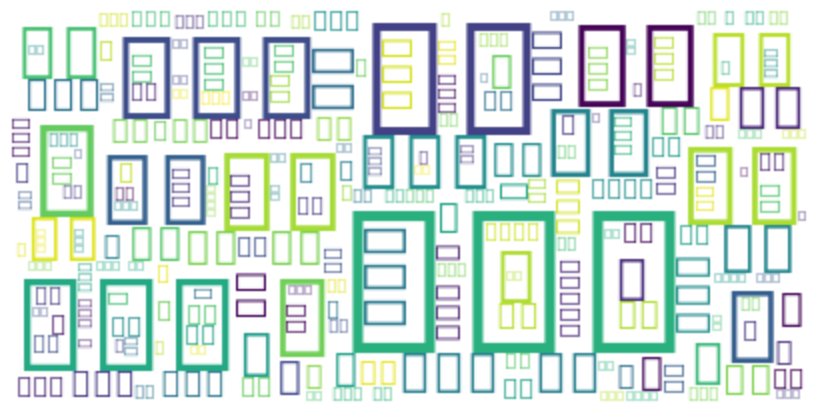

In [25]:
# ワードクラウドの表示設定と作成
wordcloud = WordCloud(
    background_color="white", max_font_size=100
).generate(' '.join(words))

# プロット
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 共起ネットワーク

### 共起マトリックス